# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [51]:
!ls -al /input

total 8308
drwxr-xr-x   4 root root    6144 Apr 29 00:27 .
drwxr-xr-x 139 root root    4096 Aug 16 16:16 ..
drwxr-xr-x   2 root root 6137856 Apr 28 19:01 img_align_celeba
drwxr-xr-x   2 root root 2365440 Apr 28 18:57 mnist


In [52]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

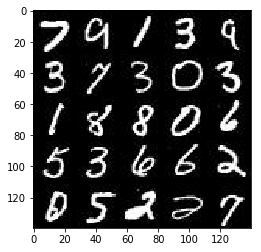

In [53]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

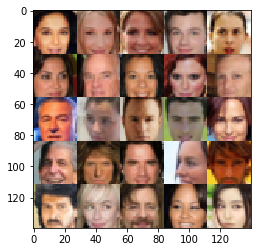

In [54]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [55]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [56]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    real_inputs = tf.placeholder(
        tf.float32, 
        (None, image_height, image_width, image_channels),
        name='real_inputs'
    )
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name='z_inputs')
    lrate = tf.placeholder(tf.float32, name='lrate')
    return real_inputs, z_inputs, lrate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [65]:
def discriminator(images, reuse=False, alpha=0.1, kernel=5, filters=64):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Input layer is 28x28x3
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, filters, kernel, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, filters*2, kernel, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, filters*4, kernel, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flat = tf.reshape(relu3, (-1, 7*7*filters*4))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [66]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1, kernel=5):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, kernel, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, kernel, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(
            x3, out_channel_dim, kernel, strides=1, padding='same')
        # 28x28x3
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)






Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [67]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(gen_model, reuse=True)
    
    ones_like_real = tf.ones_like(d_model_real)
    one_sided_smooth_labels = tf.multiply(
        ones_like_real,
        tf.random_uniform((1,), minval=0.8, maxval=1.)
    )

    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=one_sided_smooth_labels
        )
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)
        )
    )
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.ones_like(d_model_fake)
        )
    )
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [68]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [69]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [70]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    steps=0
    
    # TODO: Build Model
    image_channels = 3 if data_image_mode == 'RGB' else 1
    image_height, image_width = data_shape[1], data_shape[2]
    real_inputs, z_inputs, lrate = model_inputs(
        image_width, image_height, image_channels, z_dim)
        
    d_loss, g_loss = model_loss(real_inputs, z_inputs, image_channels)
    
    d_opt, g_opt = model_opt(d_loss, g_loss, lrate, beta1)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1
                batch_images = 2 * batch_images
                
                batch_z = np.random.uniform(-1 ,1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                    real_inputs: batch_images,
                    z_inputs: batch_z,
                    lrate: learning_rate
                })
                
                # Double the number of trains to generator
                _ = sess.run(g_opt, feed_dict={
                    z_inputs: batch_z,
                    real_inputs: batch_images,
                    lrate: learning_rate
                })
                
                
                if steps % 10 == 0:
                    # At the end of every 10 epochs, get the losses and print them out
                    train_loss_d = d_loss.eval({z_inputs: batch_z, real_inputs: batch_images})
                    train_loss_g = g_loss.eval({z_inputs: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g),
                          "Sum Loss: {:.4f}".format(train_loss_g+train_loss_d))
                
                if steps % 100 == 0:
                    show_generator_output(
                        sess,
                        25,
                        z_inputs,
                        image_channels,
                        data_image_mode
                    )
                  
        show_generator_output(sess, 25, z_inputs, image_channels, data_image_mode)

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4619... Generator Loss: 9.7782 Sum Loss: 10.2401
Epoch 1/2... Discriminator Loss: 0.5285... Generator Loss: 9.8423 Sum Loss: 10.3708
Epoch 1/2... Discriminator Loss: 0.4052... Generator Loss: 2.7723 Sum Loss: 3.1776
Epoch 1/2... Discriminator Loss: 0.3319... Generator Loss: 17.3340 Sum Loss: 17.6659
Epoch 1/2... Discriminator Loss: 0.2004... Generator Loss: 5.2486 Sum Loss: 5.4490
Epoch 1/2... Discriminator Loss: 0.3099... Generator Loss: 5.9115 Sum Loss: 6.2214
Epoch 1/2... Discriminator Loss: 0.4641... Generator Loss: 8.1758 Sum Loss: 8.6399
Epoch 1/2... Discriminator Loss: 0.7011... Generator Loss: 6.5877 Sum Loss: 7.2888
Epoch 1/2... Discriminator Loss: 0.5407... Generator Loss: 6.5125 Sum Loss: 7.0531
Epoch 1/2... Discriminator Loss: 0.2241... Generator Loss: 6.1943 Sum Loss: 6.4184


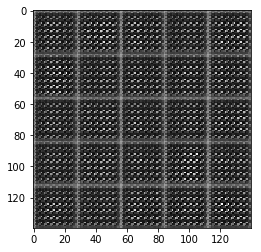

Epoch 1/2... Discriminator Loss: 0.2404... Generator Loss: 6.2842 Sum Loss: 6.5246
Epoch 1/2... Discriminator Loss: 0.3613... Generator Loss: 6.7554 Sum Loss: 7.1167
Epoch 1/2... Discriminator Loss: 0.6861... Generator Loss: 1.8346 Sum Loss: 2.5207
Epoch 1/2... Discriminator Loss: 0.7413... Generator Loss: 2.0845 Sum Loss: 2.8258
Epoch 1/2... Discriminator Loss: 0.4757... Generator Loss: 5.4999 Sum Loss: 5.9756
Epoch 1/2... Discriminator Loss: 0.3164... Generator Loss: 6.3469 Sum Loss: 6.6632
Epoch 1/2... Discriminator Loss: 0.5023... Generator Loss: 9.9390 Sum Loss: 10.4413
Epoch 1/2... Discriminator Loss: 0.8179... Generator Loss: 16.6346 Sum Loss: 17.4525
Epoch 1/2... Discriminator Loss: 0.2344... Generator Loss: 11.2059 Sum Loss: 11.4402
Epoch 1/2... Discriminator Loss: 0.5290... Generator Loss: 5.3674 Sum Loss: 5.8964


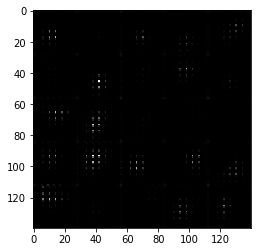

Epoch 1/2... Discriminator Loss: 0.3686... Generator Loss: 6.1082 Sum Loss: 6.4767
Epoch 1/2... Discriminator Loss: 0.3185... Generator Loss: 6.9034 Sum Loss: 7.2219
Epoch 1/2... Discriminator Loss: 0.1485... Generator Loss: 5.5618 Sum Loss: 5.7104
Epoch 1/2... Discriminator Loss: 0.4228... Generator Loss: 7.3662 Sum Loss: 7.7890
Epoch 1/2... Discriminator Loss: 0.2724... Generator Loss: 3.9911 Sum Loss: 4.2635
Epoch 1/2... Discriminator Loss: 0.4853... Generator Loss: 4.1721 Sum Loss: 4.6574
Epoch 1/2... Discriminator Loss: 1.0189... Generator Loss: 0.9988 Sum Loss: 2.0178
Epoch 1/2... Discriminator Loss: 0.5856... Generator Loss: 3.3425 Sum Loss: 3.9281
Epoch 1/2... Discriminator Loss: 0.5240... Generator Loss: 3.5539 Sum Loss: 4.0779
Epoch 1/2... Discriminator Loss: 0.3796... Generator Loss: 3.7419 Sum Loss: 4.1214


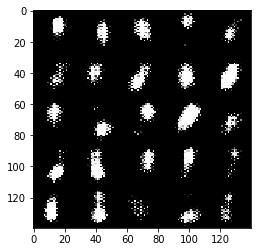

Epoch 1/2... Discriminator Loss: 0.7768... Generator Loss: 1.7769 Sum Loss: 2.5536
Epoch 1/2... Discriminator Loss: 0.5553... Generator Loss: 2.2764 Sum Loss: 2.8318
Epoch 1/2... Discriminator Loss: 0.7941... Generator Loss: 2.4172 Sum Loss: 3.2113
Epoch 1/2... Discriminator Loss: 1.0803... Generator Loss: 1.1150 Sum Loss: 2.1953
Epoch 1/2... Discriminator Loss: 1.3736... Generator Loss: 0.8917 Sum Loss: 2.2653
Epoch 1/2... Discriminator Loss: 1.0870... Generator Loss: 1.0901 Sum Loss: 2.1771
Epoch 1/2... Discriminator Loss: 0.9709... Generator Loss: 2.3567 Sum Loss: 3.3275
Epoch 1/2... Discriminator Loss: 1.2365... Generator Loss: 2.0354 Sum Loss: 3.2719
Epoch 1/2... Discriminator Loss: 1.4709... Generator Loss: 1.3636 Sum Loss: 2.8345
Epoch 1/2... Discriminator Loss: 1.5340... Generator Loss: 0.7199 Sum Loss: 2.2539


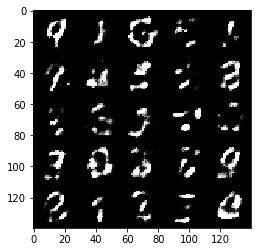

Epoch 1/2... Discriminator Loss: 0.9770... Generator Loss: 1.3630 Sum Loss: 2.3400
Epoch 1/2... Discriminator Loss: 1.2302... Generator Loss: 1.0929 Sum Loss: 2.3231
Epoch 1/2... Discriminator Loss: 1.2216... Generator Loss: 0.8153 Sum Loss: 2.0369
Epoch 1/2... Discriminator Loss: 1.2571... Generator Loss: 0.7973 Sum Loss: 2.0544
Epoch 1/2... Discriminator Loss: 1.2087... Generator Loss: 1.8413 Sum Loss: 3.0501
Epoch 1/2... Discriminator Loss: 1.2169... Generator Loss: 0.7150 Sum Loss: 1.9319
Epoch 1/2... Discriminator Loss: 1.3486... Generator Loss: 1.5277 Sum Loss: 2.8763
Epoch 1/2... Discriminator Loss: 1.6052... Generator Loss: 0.5402 Sum Loss: 2.1454
Epoch 1/2... Discriminator Loss: 1.7801... Generator Loss: 1.1838 Sum Loss: 2.9639
Epoch 1/2... Discriminator Loss: 1.4446... Generator Loss: 0.9149 Sum Loss: 2.3595


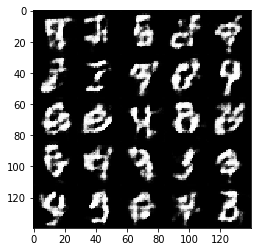

Epoch 1/2... Discriminator Loss: 1.2888... Generator Loss: 0.7558 Sum Loss: 2.0445
Epoch 1/2... Discriminator Loss: 1.5255... Generator Loss: 0.6272 Sum Loss: 2.1527
Epoch 1/2... Discriminator Loss: 1.3146... Generator Loss: 1.0814 Sum Loss: 2.3960
Epoch 1/2... Discriminator Loss: 1.2560... Generator Loss: 0.8710 Sum Loss: 2.1270
Epoch 1/2... Discriminator Loss: 1.3680... Generator Loss: 0.9052 Sum Loss: 2.2733
Epoch 1/2... Discriminator Loss: 1.2889... Generator Loss: 0.9392 Sum Loss: 2.2281
Epoch 1/2... Discriminator Loss: 1.1566... Generator Loss: 1.1237 Sum Loss: 2.2803
Epoch 1/2... Discriminator Loss: 1.2342... Generator Loss: 0.9209 Sum Loss: 2.1552
Epoch 1/2... Discriminator Loss: 1.3060... Generator Loss: 0.9272 Sum Loss: 2.2332
Epoch 1/2... Discriminator Loss: 1.1711... Generator Loss: 0.9491 Sum Loss: 2.1202


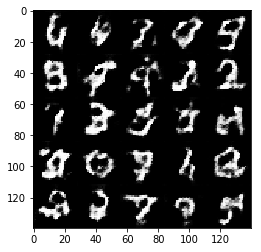

Epoch 1/2... Discriminator Loss: 1.1839... Generator Loss: 0.9308 Sum Loss: 2.1147
Epoch 1/2... Discriminator Loss: 1.2193... Generator Loss: 0.9330 Sum Loss: 2.1524
Epoch 1/2... Discriminator Loss: 1.2336... Generator Loss: 1.4340 Sum Loss: 2.6676
Epoch 1/2... Discriminator Loss: 1.1310... Generator Loss: 0.8658 Sum Loss: 1.9968
Epoch 1/2... Discriminator Loss: 1.2148... Generator Loss: 0.7486 Sum Loss: 1.9634
Epoch 1/2... Discriminator Loss: 1.1245... Generator Loss: 1.1444 Sum Loss: 2.2689
Epoch 1/2... Discriminator Loss: 1.1508... Generator Loss: 1.0076 Sum Loss: 2.1584
Epoch 1/2... Discriminator Loss: 1.1592... Generator Loss: 0.9375 Sum Loss: 2.0967
Epoch 1/2... Discriminator Loss: 1.2301... Generator Loss: 1.1664 Sum Loss: 2.3965
Epoch 1/2... Discriminator Loss: 1.1718... Generator Loss: 1.1350 Sum Loss: 2.3067


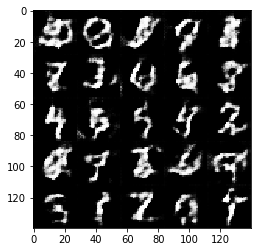

Epoch 1/2... Discriminator Loss: 1.1683... Generator Loss: 1.1874 Sum Loss: 2.3557
Epoch 1/2... Discriminator Loss: 1.2173... Generator Loss: 1.0415 Sum Loss: 2.2588
Epoch 1/2... Discriminator Loss: 1.1428... Generator Loss: 0.9700 Sum Loss: 2.1128
Epoch 1/2... Discriminator Loss: 1.3420... Generator Loss: 0.5281 Sum Loss: 1.8701
Epoch 1/2... Discriminator Loss: 1.1813... Generator Loss: 0.8032 Sum Loss: 1.9845
Epoch 1/2... Discriminator Loss: 1.1671... Generator Loss: 1.0266 Sum Loss: 2.1936
Epoch 1/2... Discriminator Loss: 1.1245... Generator Loss: 0.8846 Sum Loss: 2.0092
Epoch 1/2... Discriminator Loss: 1.1862... Generator Loss: 1.2653 Sum Loss: 2.4514
Epoch 1/2... Discriminator Loss: 1.1858... Generator Loss: 1.0618 Sum Loss: 2.2476
Epoch 1/2... Discriminator Loss: 1.2274... Generator Loss: 1.3486 Sum Loss: 2.5760


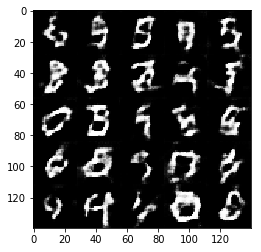

Epoch 1/2... Discriminator Loss: 1.2103... Generator Loss: 1.2271 Sum Loss: 2.4375
Epoch 1/2... Discriminator Loss: 1.1623... Generator Loss: 1.0465 Sum Loss: 2.2088
Epoch 1/2... Discriminator Loss: 1.2451... Generator Loss: 0.8976 Sum Loss: 2.1428
Epoch 1/2... Discriminator Loss: 1.3870... Generator Loss: 1.3106 Sum Loss: 2.6976
Epoch 1/2... Discriminator Loss: 1.1797... Generator Loss: 1.1259 Sum Loss: 2.3056
Epoch 1/2... Discriminator Loss: 1.1389... Generator Loss: 0.8915 Sum Loss: 2.0304
Epoch 1/2... Discriminator Loss: 1.2708... Generator Loss: 0.6881 Sum Loss: 1.9588
Epoch 1/2... Discriminator Loss: 1.2892... Generator Loss: 0.9604 Sum Loss: 2.2496
Epoch 1/2... Discriminator Loss: 1.2049... Generator Loss: 1.0287 Sum Loss: 2.2337
Epoch 1/2... Discriminator Loss: 1.2460... Generator Loss: 1.0713 Sum Loss: 2.3173


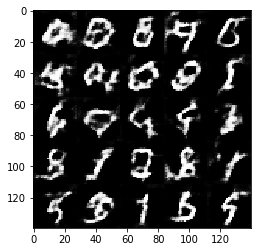

Epoch 1/2... Discriminator Loss: 1.2592... Generator Loss: 0.9984 Sum Loss: 2.2576
Epoch 1/2... Discriminator Loss: 1.1757... Generator Loss: 0.9447 Sum Loss: 2.1204
Epoch 1/2... Discriminator Loss: 1.1983... Generator Loss: 0.9104 Sum Loss: 2.1088
Epoch 2/2... Discriminator Loss: 1.2206... Generator Loss: 1.1567 Sum Loss: 2.3773
Epoch 2/2... Discriminator Loss: 1.2143... Generator Loss: 0.9097 Sum Loss: 2.1240
Epoch 2/2... Discriminator Loss: 1.2232... Generator Loss: 0.9777 Sum Loss: 2.2009
Epoch 2/2... Discriminator Loss: 1.2124... Generator Loss: 1.1516 Sum Loss: 2.3641
Epoch 2/2... Discriminator Loss: 1.2201... Generator Loss: 0.8697 Sum Loss: 2.0898
Epoch 2/2... Discriminator Loss: 1.2884... Generator Loss: 0.7412 Sum Loss: 2.0297
Epoch 2/2... Discriminator Loss: 1.2371... Generator Loss: 0.7743 Sum Loss: 2.0114


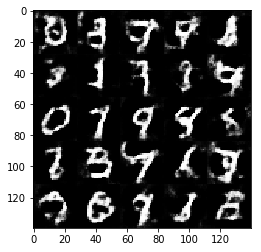

Epoch 2/2... Discriminator Loss: 1.2684... Generator Loss: 0.7813 Sum Loss: 2.0496
Epoch 2/2... Discriminator Loss: 1.3407... Generator Loss: 0.6860 Sum Loss: 2.0268
Epoch 2/2... Discriminator Loss: 1.2132... Generator Loss: 0.7972 Sum Loss: 2.0104
Epoch 2/2... Discriminator Loss: 1.2982... Generator Loss: 0.7585 Sum Loss: 2.0568
Epoch 2/2... Discriminator Loss: 1.2697... Generator Loss: 1.1317 Sum Loss: 2.4015
Epoch 2/2... Discriminator Loss: 1.2867... Generator Loss: 0.8297 Sum Loss: 2.1164
Epoch 2/2... Discriminator Loss: 1.1983... Generator Loss: 0.8946 Sum Loss: 2.0929
Epoch 2/2... Discriminator Loss: 1.2677... Generator Loss: 1.3261 Sum Loss: 2.5938
Epoch 2/2... Discriminator Loss: 1.2829... Generator Loss: 0.8629 Sum Loss: 2.1457
Epoch 2/2... Discriminator Loss: 1.2283... Generator Loss: 0.9820 Sum Loss: 2.2103


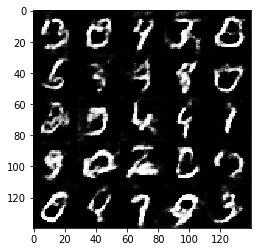

Epoch 2/2... Discriminator Loss: 1.3756... Generator Loss: 1.2277 Sum Loss: 2.6033
Epoch 2/2... Discriminator Loss: 1.2942... Generator Loss: 1.0355 Sum Loss: 2.3297
Epoch 2/2... Discriminator Loss: 1.2570... Generator Loss: 0.8545 Sum Loss: 2.1115
Epoch 2/2... Discriminator Loss: 1.2764... Generator Loss: 1.1438 Sum Loss: 2.4201
Epoch 2/2... Discriminator Loss: 1.3039... Generator Loss: 0.7144 Sum Loss: 2.0182
Epoch 2/2... Discriminator Loss: 1.3308... Generator Loss: 0.7068 Sum Loss: 2.0375
Epoch 2/2... Discriminator Loss: 1.2555... Generator Loss: 1.0406 Sum Loss: 2.2961
Epoch 2/2... Discriminator Loss: 1.2768... Generator Loss: 0.7375 Sum Loss: 2.0143
Epoch 2/2... Discriminator Loss: 1.2737... Generator Loss: 0.7185 Sum Loss: 1.9922
Epoch 2/2... Discriminator Loss: 1.2171... Generator Loss: 0.7652 Sum Loss: 1.9823


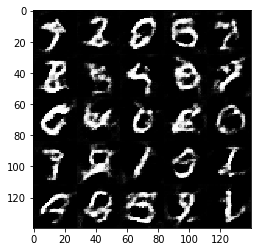

Epoch 2/2... Discriminator Loss: 1.3414... Generator Loss: 1.2716 Sum Loss: 2.6131
Epoch 2/2... Discriminator Loss: 1.3266... Generator Loss: 0.5650 Sum Loss: 1.8916
Epoch 2/2... Discriminator Loss: 1.3294... Generator Loss: 0.7700 Sum Loss: 2.0994
Epoch 2/2... Discriminator Loss: 1.2125... Generator Loss: 0.7292 Sum Loss: 1.9417
Epoch 2/2... Discriminator Loss: 1.1774... Generator Loss: 0.9593 Sum Loss: 2.1367
Epoch 2/2... Discriminator Loss: 1.3418... Generator Loss: 0.9982 Sum Loss: 2.3399
Epoch 2/2... Discriminator Loss: 1.2145... Generator Loss: 0.9840 Sum Loss: 2.1985
Epoch 2/2... Discriminator Loss: 1.1949... Generator Loss: 1.1481 Sum Loss: 2.3430
Epoch 2/2... Discriminator Loss: 1.1875... Generator Loss: 0.6263 Sum Loss: 1.8138
Epoch 2/2... Discriminator Loss: 1.2123... Generator Loss: 0.9229 Sum Loss: 2.1352


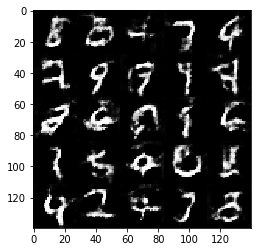

Epoch 2/2... Discriminator Loss: 1.2394... Generator Loss: 0.9009 Sum Loss: 2.1403
Epoch 2/2... Discriminator Loss: 1.1945... Generator Loss: 0.8652 Sum Loss: 2.0598
Epoch 2/2... Discriminator Loss: 1.1698... Generator Loss: 0.7907 Sum Loss: 1.9604
Epoch 2/2... Discriminator Loss: 1.3539... Generator Loss: 1.2380 Sum Loss: 2.5919
Epoch 2/2... Discriminator Loss: 1.2333... Generator Loss: 0.9670 Sum Loss: 2.2004
Epoch 2/2... Discriminator Loss: 1.4319... Generator Loss: 0.6113 Sum Loss: 2.0433
Epoch 2/2... Discriminator Loss: 1.2435... Generator Loss: 1.0128 Sum Loss: 2.2563
Epoch 2/2... Discriminator Loss: 1.2993... Generator Loss: 0.6878 Sum Loss: 1.9871
Epoch 2/2... Discriminator Loss: 1.1143... Generator Loss: 1.1236 Sum Loss: 2.2379
Epoch 2/2... Discriminator Loss: 1.3513... Generator Loss: 0.6472 Sum Loss: 1.9984


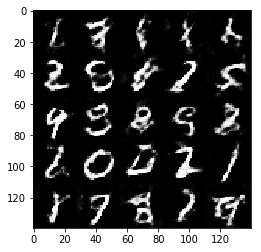

Epoch 2/2... Discriminator Loss: 1.2993... Generator Loss: 0.7387 Sum Loss: 2.0381
Epoch 2/2... Discriminator Loss: 1.2568... Generator Loss: 1.0721 Sum Loss: 2.3288
Epoch 2/2... Discriminator Loss: 1.3307... Generator Loss: 0.7280 Sum Loss: 2.0587
Epoch 2/2... Discriminator Loss: 1.2442... Generator Loss: 0.9265 Sum Loss: 2.1707
Epoch 2/2... Discriminator Loss: 1.2715... Generator Loss: 0.9330 Sum Loss: 2.2045
Epoch 2/2... Discriminator Loss: 1.2043... Generator Loss: 1.1277 Sum Loss: 2.3320
Epoch 2/2... Discriminator Loss: 1.1867... Generator Loss: 0.7721 Sum Loss: 1.9588
Epoch 2/2... Discriminator Loss: 1.2405... Generator Loss: 0.7314 Sum Loss: 1.9719
Epoch 2/2... Discriminator Loss: 1.4138... Generator Loss: 0.6942 Sum Loss: 2.1080
Epoch 2/2... Discriminator Loss: 1.2168... Generator Loss: 0.9188 Sum Loss: 2.1356


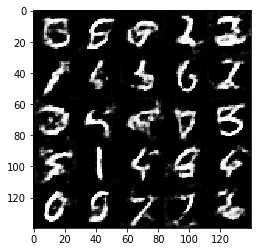

Epoch 2/2... Discriminator Loss: 1.2630... Generator Loss: 0.7080 Sum Loss: 1.9710
Epoch 2/2... Discriminator Loss: 1.3330... Generator Loss: 0.6697 Sum Loss: 2.0027
Epoch 2/2... Discriminator Loss: 1.2611... Generator Loss: 0.9544 Sum Loss: 2.2155
Epoch 2/2... Discriminator Loss: 1.2449... Generator Loss: 1.0253 Sum Loss: 2.2703
Epoch 2/2... Discriminator Loss: 1.2319... Generator Loss: 0.9412 Sum Loss: 2.1731
Epoch 2/2... Discriminator Loss: 1.2808... Generator Loss: 0.9214 Sum Loss: 2.2022
Epoch 2/2... Discriminator Loss: 1.3605... Generator Loss: 0.8203 Sum Loss: 2.1808
Epoch 2/2... Discriminator Loss: 1.2413... Generator Loss: 0.6995 Sum Loss: 1.9408
Epoch 2/2... Discriminator Loss: 1.2814... Generator Loss: 0.8469 Sum Loss: 2.1283
Epoch 2/2... Discriminator Loss: 1.3556... Generator Loss: 0.7316 Sum Loss: 2.0872


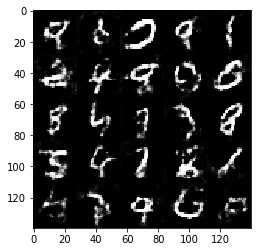

Epoch 2/2... Discriminator Loss: 1.2251... Generator Loss: 0.8868 Sum Loss: 2.1119
Epoch 2/2... Discriminator Loss: 1.4178... Generator Loss: 0.5807 Sum Loss: 1.9985
Epoch 2/2... Discriminator Loss: 1.2656... Generator Loss: 0.9346 Sum Loss: 2.2002
Epoch 2/2... Discriminator Loss: 1.3591... Generator Loss: 0.7354 Sum Loss: 2.0944
Epoch 2/2... Discriminator Loss: 1.2310... Generator Loss: 1.0421 Sum Loss: 2.2731
Epoch 2/2... Discriminator Loss: 1.2841... Generator Loss: 0.8628 Sum Loss: 2.1469
Epoch 2/2... Discriminator Loss: 1.2620... Generator Loss: 1.1400 Sum Loss: 2.4019
Epoch 2/2... Discriminator Loss: 1.2495... Generator Loss: 0.9439 Sum Loss: 2.1934
Epoch 2/2... Discriminator Loss: 1.2853... Generator Loss: 0.9631 Sum Loss: 2.2484
Epoch 2/2... Discriminator Loss: 1.1857... Generator Loss: 0.9637 Sum Loss: 2.1494


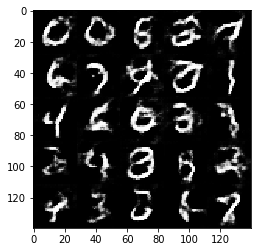

Epoch 2/2... Discriminator Loss: 1.3858... Generator Loss: 0.7074 Sum Loss: 2.0932
Epoch 2/2... Discriminator Loss: 1.2373... Generator Loss: 0.8418 Sum Loss: 2.0791
Epoch 2/2... Discriminator Loss: 1.2755... Generator Loss: 1.1333 Sum Loss: 2.4088
Epoch 2/2... Discriminator Loss: 1.3090... Generator Loss: 0.6824 Sum Loss: 1.9914
Epoch 2/2... Discriminator Loss: 1.3063... Generator Loss: 0.6823 Sum Loss: 1.9886
Epoch 2/2... Discriminator Loss: 1.2414... Generator Loss: 1.0190 Sum Loss: 2.2604
Epoch 2/2... Discriminator Loss: 1.2992... Generator Loss: 0.7667 Sum Loss: 2.0659
Epoch 2/2... Discriminator Loss: 1.1738... Generator Loss: 0.7827 Sum Loss: 1.9565
Epoch 2/2... Discriminator Loss: 1.3127... Generator Loss: 1.0497 Sum Loss: 2.3624
Epoch 2/2... Discriminator Loss: 1.2977... Generator Loss: 1.0448 Sum Loss: 2.3425


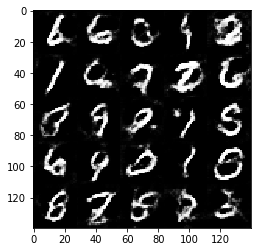

Epoch 2/2... Discriminator Loss: 1.2542... Generator Loss: 1.0089 Sum Loss: 2.2630
Epoch 2/2... Discriminator Loss: 1.2730... Generator Loss: 0.7362 Sum Loss: 2.0092
Epoch 2/2... Discriminator Loss: 1.2867... Generator Loss: 1.0038 Sum Loss: 2.2905
Epoch 2/2... Discriminator Loss: 1.2997... Generator Loss: 0.7506 Sum Loss: 2.0503
Epoch 2/2... Discriminator Loss: 1.2261... Generator Loss: 0.9491 Sum Loss: 2.1751
Epoch 2/2... Discriminator Loss: 1.2896... Generator Loss: 0.8044 Sum Loss: 2.0940
Epoch 2/2... Discriminator Loss: 1.3359... Generator Loss: 1.1017 Sum Loss: 2.4377


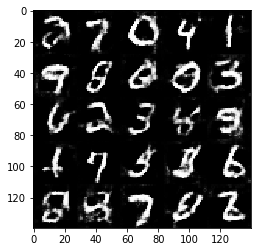

In [71]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4520... Generator Loss: 5.4299 Sum Loss: 5.8819
Epoch 1/1... Discriminator Loss: 0.2774... Generator Loss: 3.2095 Sum Loss: 3.4869
Epoch 1/1... Discriminator Loss: 0.5556... Generator Loss: 8.4805 Sum Loss: 9.0361
Epoch 1/1... Discriminator Loss: 0.3654... Generator Loss: 2.7009 Sum Loss: 3.0662
Epoch 1/1... Discriminator Loss: 0.5781... Generator Loss: 4.6462 Sum Loss: 5.2243
Epoch 1/1... Discriminator Loss: 0.5891... Generator Loss: 14.8055 Sum Loss: 15.3946
Epoch 1/1... Discriminator Loss: 0.3696... Generator Loss: 9.5141 Sum Loss: 9.8837
Epoch 1/1... Discriminator Loss: 0.0817... Generator Loss: 3.9737 Sum Loss: 4.0554
Epoch 1/1... Discriminator Loss: 0.2072... Generator Loss: 2.4947 Sum Loss: 2.7019
Epoch 1/1... Discriminator Loss: 0.1659... Generator Loss: 5.6189 Sum Loss: 5.7848


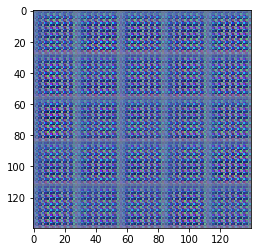

Epoch 1/1... Discriminator Loss: 0.6387... Generator Loss: 3.5894 Sum Loss: 4.2281
Epoch 1/1... Discriminator Loss: 0.1298... Generator Loss: 5.3695 Sum Loss: 5.4993
Epoch 1/1... Discriminator Loss: 0.4488... Generator Loss: 2.0828 Sum Loss: 2.5316
Epoch 1/1... Discriminator Loss: 0.4209... Generator Loss: 5.0109 Sum Loss: 5.4318
Epoch 1/1... Discriminator Loss: 0.2937... Generator Loss: 2.9576 Sum Loss: 3.2514
Epoch 1/1... Discriminator Loss: 0.3966... Generator Loss: 4.7214 Sum Loss: 5.1180
Epoch 1/1... Discriminator Loss: 0.2097... Generator Loss: 2.3708 Sum Loss: 2.5805
Epoch 1/1... Discriminator Loss: 1.5237... Generator Loss: 4.8502 Sum Loss: 6.3739
Epoch 1/1... Discriminator Loss: 0.8027... Generator Loss: 2.3677 Sum Loss: 3.1704
Epoch 1/1... Discriminator Loss: 1.7048... Generator Loss: 0.6606 Sum Loss: 2.3655


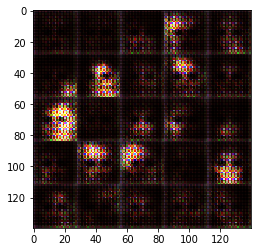

Epoch 1/1... Discriminator Loss: 0.8302... Generator Loss: 2.5807 Sum Loss: 3.4109
Epoch 1/1... Discriminator Loss: 0.7007... Generator Loss: 1.4813 Sum Loss: 2.1820
Epoch 1/1... Discriminator Loss: 0.7477... Generator Loss: 1.8201 Sum Loss: 2.5677
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 0.6619 Sum Loss: 1.8544
Epoch 1/1... Discriminator Loss: 0.7677... Generator Loss: 1.6341 Sum Loss: 2.4018
Epoch 1/1... Discriminator Loss: 0.7246... Generator Loss: 2.1512 Sum Loss: 2.8757
Epoch 1/1... Discriminator Loss: 0.6589... Generator Loss: 2.3353 Sum Loss: 2.9942
Epoch 1/1... Discriminator Loss: 0.5831... Generator Loss: 3.0125 Sum Loss: 3.5956
Epoch 1/1... Discriminator Loss: 0.5435... Generator Loss: 1.7843 Sum Loss: 2.3278
Epoch 1/1... Discriminator Loss: 0.5748... Generator Loss: 1.8508 Sum Loss: 2.4256


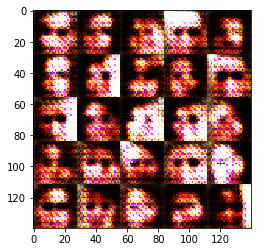

Epoch 1/1... Discriminator Loss: 0.4015... Generator Loss: 3.7962 Sum Loss: 4.1977
Epoch 1/1... Discriminator Loss: 0.4380... Generator Loss: 2.9095 Sum Loss: 3.3475
Epoch 1/1... Discriminator Loss: 0.2477... Generator Loss: 3.2183 Sum Loss: 3.4660
Epoch 1/1... Discriminator Loss: 0.3926... Generator Loss: 2.8971 Sum Loss: 3.2897
Epoch 1/1... Discriminator Loss: 0.8797... Generator Loss: 0.9267 Sum Loss: 1.8064
Epoch 1/1... Discriminator Loss: 0.4536... Generator Loss: 2.8636 Sum Loss: 3.3173
Epoch 1/1... Discriminator Loss: 0.8216... Generator Loss: 4.1859 Sum Loss: 5.0075
Epoch 1/1... Discriminator Loss: 0.4000... Generator Loss: 2.9657 Sum Loss: 3.3657
Epoch 1/1... Discriminator Loss: 0.5148... Generator Loss: 4.4606 Sum Loss: 4.9753
Epoch 1/1... Discriminator Loss: 0.3590... Generator Loss: 2.2791 Sum Loss: 2.6381


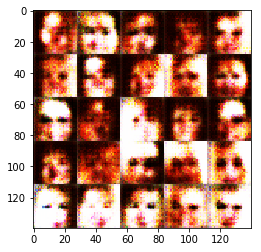

Epoch 1/1... Discriminator Loss: 0.7820... Generator Loss: 2.0575 Sum Loss: 2.8395
Epoch 1/1... Discriminator Loss: 0.7170... Generator Loss: 2.2573 Sum Loss: 2.9744
Epoch 1/1... Discriminator Loss: 0.6016... Generator Loss: 4.1272 Sum Loss: 4.7288
Epoch 1/1... Discriminator Loss: 0.7101... Generator Loss: 1.6609 Sum Loss: 2.3711
Epoch 1/1... Discriminator Loss: 0.6269... Generator Loss: 2.9326 Sum Loss: 3.5595
Epoch 1/1... Discriminator Loss: 0.8166... Generator Loss: 1.7359 Sum Loss: 2.5525
Epoch 1/1... Discriminator Loss: 0.7576... Generator Loss: 1.7057 Sum Loss: 2.4632
Epoch 1/1... Discriminator Loss: 0.8729... Generator Loss: 1.7407 Sum Loss: 2.6135
Epoch 1/1... Discriminator Loss: 0.7725... Generator Loss: 1.4301 Sum Loss: 2.2026
Epoch 1/1... Discriminator Loss: 1.5777... Generator Loss: 0.4287 Sum Loss: 2.0064


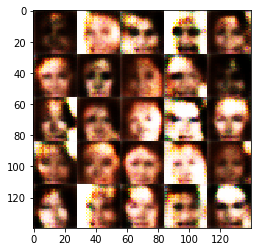

Epoch 1/1... Discriminator Loss: 0.6712... Generator Loss: 3.1112 Sum Loss: 3.7824
Epoch 1/1... Discriminator Loss: 0.7569... Generator Loss: 1.4681 Sum Loss: 2.2251
Epoch 1/1... Discriminator Loss: 0.9615... Generator Loss: 1.3376 Sum Loss: 2.2991
Epoch 1/1... Discriminator Loss: 0.7019... Generator Loss: 2.5663 Sum Loss: 3.2682
Epoch 1/1... Discriminator Loss: 0.8158... Generator Loss: 1.7220 Sum Loss: 2.5378
Epoch 1/1... Discriminator Loss: 1.1459... Generator Loss: 2.0608 Sum Loss: 3.2067
Epoch 1/1... Discriminator Loss: 1.0887... Generator Loss: 2.2290 Sum Loss: 3.3178
Epoch 1/1... Discriminator Loss: 2.0488... Generator Loss: 0.3504 Sum Loss: 2.3992
Epoch 1/1... Discriminator Loss: 0.9276... Generator Loss: 1.1889 Sum Loss: 2.1165
Epoch 1/1... Discriminator Loss: 0.4936... Generator Loss: 2.4979 Sum Loss: 2.9915


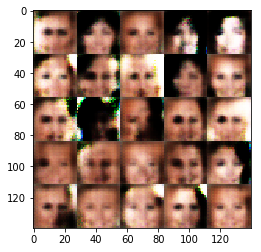

Epoch 1/1... Discriminator Loss: 1.1456... Generator Loss: 0.8099 Sum Loss: 1.9555
Epoch 1/1... Discriminator Loss: 1.7977... Generator Loss: 0.3356 Sum Loss: 2.1334
Epoch 1/1... Discriminator Loss: 1.0197... Generator Loss: 2.7841 Sum Loss: 3.8038
Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 0.7973 Sum Loss: 1.9154
Epoch 1/1... Discriminator Loss: 0.9034... Generator Loss: 1.0319 Sum Loss: 1.9353
Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 0.6541 Sum Loss: 1.8167
Epoch 1/1... Discriminator Loss: 0.8553... Generator Loss: 1.0791 Sum Loss: 1.9345
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.6405 Sum Loss: 1.9601
Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 2.5514 Sum Loss: 3.6145
Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.7054 Sum Loss: 1.9800


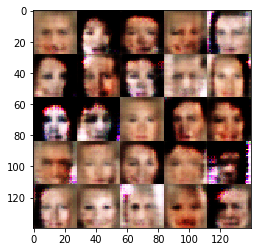

Epoch 1/1... Discriminator Loss: 0.9938... Generator Loss: 1.2321 Sum Loss: 2.2260
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.6281 Sum Loss: 2.0645
Epoch 1/1... Discriminator Loss: 0.9507... Generator Loss: 1.1662 Sum Loss: 2.1168
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 1.3779 Sum Loss: 2.6085
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 2.0581 Sum Loss: 3.3679
Epoch 1/1... Discriminator Loss: 1.8191... Generator Loss: 0.2722 Sum Loss: 2.0913
Epoch 1/1... Discriminator Loss: 1.0732... Generator Loss: 1.9075 Sum Loss: 2.9806
Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 0.7590 Sum Loss: 1.9845
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.8105 Sum Loss: 2.1222
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 0.8917 Sum Loss: 2.0352


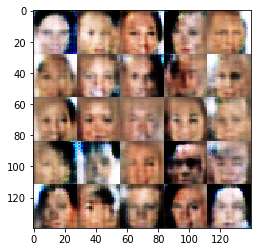

Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.6947 Sum Loss: 2.0459
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.6448 Sum Loss: 2.0156
Epoch 1/1... Discriminator Loss: 1.6496... Generator Loss: 2.0928 Sum Loss: 3.7423
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 0.8062 Sum Loss: 2.0429
Epoch 1/1... Discriminator Loss: 1.1019... Generator Loss: 1.2999 Sum Loss: 2.4018
Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 0.8166 Sum Loss: 2.0406
Epoch 1/1... Discriminator Loss: 1.0644... Generator Loss: 1.7139 Sum Loss: 2.7783
Epoch 1/1... Discriminator Loss: 1.5342... Generator Loss: 0.4738 Sum Loss: 2.0081
Epoch 1/1... Discriminator Loss: 1.0194... Generator Loss: 1.7089 Sum Loss: 2.7283
Epoch 1/1... Discriminator Loss: 1.5325... Generator Loss: 0.5384 Sum Loss: 2.0708


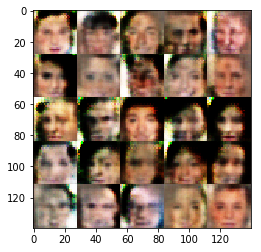

Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 0.7402 Sum Loss: 2.0085
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.5331 Sum Loss: 1.9444
Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 0.8133 Sum Loss: 1.9619
Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 1.6652 Sum Loss: 2.8534
Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.6340 Sum Loss: 2.0988
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.4725 Sum Loss: 1.8338
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.7669 Sum Loss: 2.0546
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 1.3280 Sum Loss: 2.4372
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.5365 Sum Loss: 1.7970
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.7053 Sum Loss: 2.1453


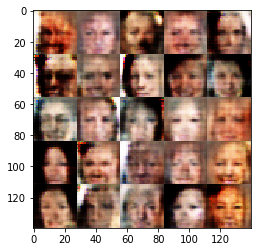

Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 0.7174 Sum Loss: 1.9811
Epoch 1/1... Discriminator Loss: 0.9772... Generator Loss: 1.6765 Sum Loss: 2.6537
Epoch 1/1... Discriminator Loss: 0.9966... Generator Loss: 1.0919 Sum Loss: 2.0885
Epoch 1/1... Discriminator Loss: 1.0741... Generator Loss: 1.4451 Sum Loss: 2.5192
Epoch 1/1... Discriminator Loss: 1.4730... Generator Loss: 0.5825 Sum Loss: 2.0555
Epoch 1/1... Discriminator Loss: 1.1774... Generator Loss: 1.2817 Sum Loss: 2.4592
Epoch 1/1... Discriminator Loss: 0.9687... Generator Loss: 2.0086 Sum Loss: 2.9772
Epoch 1/1... Discriminator Loss: 1.9037... Generator Loss: 0.3372 Sum Loss: 2.2409
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.7278 Sum Loss: 2.0237
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.8749 Sum Loss: 2.3181


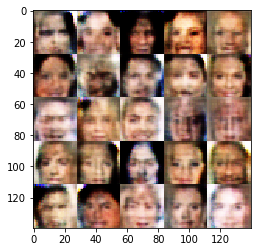

Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 1.0978 Sum Loss: 2.1985
Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 1.0684 Sum Loss: 2.2320
Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 0.8299 Sum Loss: 2.1158
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.7020 Sum Loss: 2.0049
Epoch 1/1... Discriminator Loss: 1.4841... Generator Loss: 0.5389 Sum Loss: 2.0230
Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 0.8562 Sum Loss: 2.0295
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.6143 Sum Loss: 1.9370
Epoch 1/1... Discriminator Loss: 0.9736... Generator Loss: 1.6615 Sum Loss: 2.6351
Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 1.1938 Sum Loss: 2.5090
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.6578 Sum Loss: 2.0743


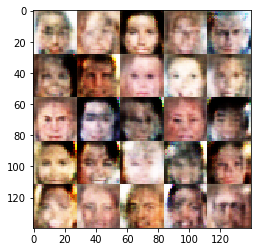

Epoch 1/1... Discriminator Loss: 1.5921... Generator Loss: 1.6162 Sum Loss: 3.2083
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.8541 Sum Loss: 2.0442
Epoch 1/1... Discriminator Loss: 2.1305... Generator Loss: 2.7020 Sum Loss: 4.8325
Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 0.8982 Sum Loss: 2.1283
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 0.9489 Sum Loss: 2.1714
Epoch 1/1... Discriminator Loss: 1.7762... Generator Loss: 0.3920 Sum Loss: 2.1682
Epoch 1/1... Discriminator Loss: 1.5968... Generator Loss: 1.0289 Sum Loss: 2.6257
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.8325 Sum Loss: 2.2530
Epoch 1/1... Discriminator Loss: 1.5971... Generator Loss: 0.8280 Sum Loss: 2.4251
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.9005 Sum Loss: 2.2786


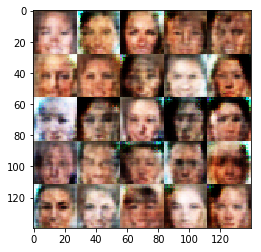

Epoch 1/1... Discriminator Loss: 1.5346... Generator Loss: 0.4827 Sum Loss: 2.0173
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.5996 Sum Loss: 1.9961
Epoch 1/1... Discriminator Loss: 1.0602... Generator Loss: 0.9343 Sum Loss: 1.9945
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 1.2082 Sum Loss: 2.4761
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.6902 Sum Loss: 2.0754
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.9031 Sum Loss: 2.2366
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.7358 Sum Loss: 2.1431
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.7763 Sum Loss: 2.1642
Epoch 1/1... Discriminator Loss: 0.8975... Generator Loss: 1.7103 Sum Loss: 2.6079
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 1.0078 Sum Loss: 2.2778


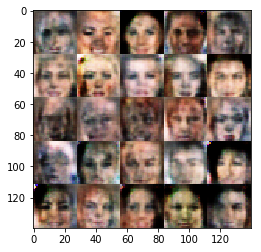

Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.7793 Sum Loss: 2.1316
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 1.0554 Sum Loss: 2.2943
Epoch 1/1... Discriminator Loss: 1.1046... Generator Loss: 1.1120 Sum Loss: 2.2166
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 1.1962 Sum Loss: 2.4722
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.6126 Sum Loss: 1.9367
Epoch 1/1... Discriminator Loss: 0.7976... Generator Loss: 2.1842 Sum Loss: 2.9818
Epoch 1/1... Discriminator Loss: 1.2145... Generator Loss: 0.9993 Sum Loss: 2.2138
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 1.2326 Sum Loss: 2.5177
Epoch 1/1... Discriminator Loss: 1.0886... Generator Loss: 1.6181 Sum Loss: 2.7067
Epoch 1/1... Discriminator Loss: 1.5671... Generator Loss: 0.3269 Sum Loss: 1.8940


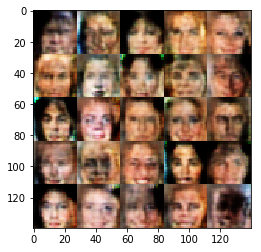

Epoch 1/1... Discriminator Loss: 1.1630... Generator Loss: 1.0861 Sum Loss: 2.2491
Epoch 1/1... Discriminator Loss: 1.0734... Generator Loss: 1.7712 Sum Loss: 2.8446
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.4764 Sum Loss: 1.7344
Epoch 1/1... Discriminator Loss: 1.0125... Generator Loss: 0.9594 Sum Loss: 1.9719
Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 1.2678 Sum Loss: 2.5030
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.4616 Sum Loss: 1.9227
Epoch 1/1... Discriminator Loss: 1.0283... Generator Loss: 1.6069 Sum Loss: 2.6352
Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 0.7274 Sum Loss: 1.9956
Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 0.9774 Sum Loss: 2.2486
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.6743 Sum Loss: 1.9978


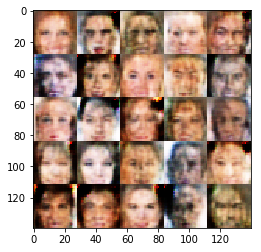

Epoch 1/1... Discriminator Loss: 1.7528... Generator Loss: 0.3135 Sum Loss: 2.0662
Epoch 1/1... Discriminator Loss: 1.2345... Generator Loss: 1.1141 Sum Loss: 2.3486
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.6511 Sum Loss: 1.9459
Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 1.3196 Sum Loss: 2.1889
Epoch 1/1... Discriminator Loss: 0.8912... Generator Loss: 1.5716 Sum Loss: 2.4628
Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.9525 Sum Loss: 2.1766
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 0.8011 Sum Loss: 2.0375
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 0.9543 Sum Loss: 2.1930
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.6063 Sum Loss: 1.9299
Epoch 1/1... Discriminator Loss: 1.5349... Generator Loss: 1.9665 Sum Loss: 3.5014


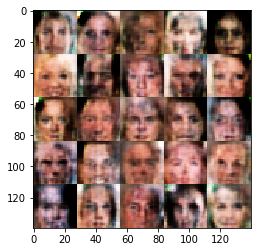

Epoch 1/1... Discriminator Loss: 1.5079... Generator Loss: 0.6719 Sum Loss: 2.1799
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 1.2298 Sum Loss: 2.6415
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 2.2488 Sum Loss: 3.7029
Epoch 1/1... Discriminator Loss: 1.1996... Generator Loss: 1.1969 Sum Loss: 2.3965
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 0.9901 Sum Loss: 2.1456
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 1.1052 Sum Loss: 2.2541
Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 2.0412 Sum Loss: 3.0025
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 1.1988 Sum Loss: 2.5106
Epoch 1/1... Discriminator Loss: 1.4695... Generator Loss: 1.2664 Sum Loss: 2.7359
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.6271 Sum Loss: 1.9735


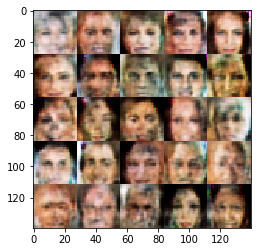

Epoch 1/1... Discriminator Loss: 0.8111... Generator Loss: 1.5919 Sum Loss: 2.4030
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 0.9495 Sum Loss: 2.1242
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 1.0863 Sum Loss: 2.3059
Epoch 1/1... Discriminator Loss: 1.1819... Generator Loss: 0.7947 Sum Loss: 1.9766
Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 0.8996 Sum Loss: 2.0690
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 1.2146 Sum Loss: 2.5323
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 0.9472 Sum Loss: 2.0801
Epoch 1/1... Discriminator Loss: 1.5651... Generator Loss: 0.4808 Sum Loss: 2.0460
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.7344 Sum Loss: 2.0141
Epoch 1/1... Discriminator Loss: 1.1034... Generator Loss: 1.0288 Sum Loss: 2.1323


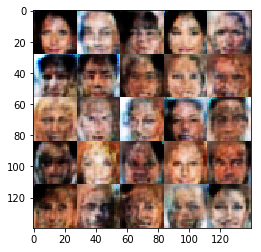

Epoch 1/1... Discriminator Loss: 1.5474... Generator Loss: 0.4704 Sum Loss: 2.0178
Epoch 1/1... Discriminator Loss: 0.5702... Generator Loss: 2.3594 Sum Loss: 2.9297
Epoch 1/1... Discriminator Loss: 1.1548... Generator Loss: 1.1950 Sum Loss: 2.3498
Epoch 1/1... Discriminator Loss: 0.9446... Generator Loss: 1.5338 Sum Loss: 2.4785
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.8126 Sum Loss: 2.0802
Epoch 1/1... Discriminator Loss: 0.8831... Generator Loss: 1.8665 Sum Loss: 2.7496
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 1.5051 Sum Loss: 2.6719
Epoch 1/1... Discriminator Loss: 0.6126... Generator Loss: 2.6970 Sum Loss: 3.3096
Epoch 1/1... Discriminator Loss: 1.0831... Generator Loss: 1.6526 Sum Loss: 2.7357
Epoch 1/1... Discriminator Loss: 0.9834... Generator Loss: 2.6790 Sum Loss: 3.6625


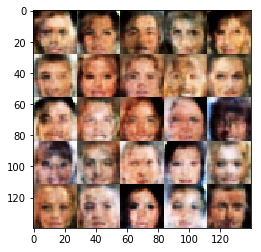

Epoch 1/1... Discriminator Loss: 1.8557... Generator Loss: 2.5990 Sum Loss: 4.4547
Epoch 1/1... Discriminator Loss: 1.1038... Generator Loss: 1.2894 Sum Loss: 2.3931
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 1.1668 Sum Loss: 2.2891
Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 1.3858 Sum Loss: 2.6566
Epoch 1/1... Discriminator Loss: 1.5714... Generator Loss: 0.4786 Sum Loss: 2.0500
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.7173 Sum Loss: 2.0382
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 1.2333 Sum Loss: 2.3883
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.5534 Sum Loss: 1.9817
Epoch 1/1... Discriminator Loss: 0.8157... Generator Loss: 1.9616 Sum Loss: 2.7773
Epoch 1/1... Discriminator Loss: 2.4069... Generator Loss: 2.3942 Sum Loss: 4.8011


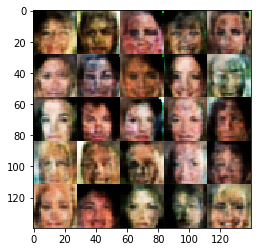

Epoch 1/1... Discriminator Loss: 0.9193... Generator Loss: 1.6615 Sum Loss: 2.5807
Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 0.8372 Sum Loss: 2.0798
Epoch 1/1... Discriminator Loss: 1.1578... Generator Loss: 0.8572 Sum Loss: 2.0149
Epoch 1/1... Discriminator Loss: 1.0387... Generator Loss: 1.3312 Sum Loss: 2.3699
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.9294 Sum Loss: 2.1880
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 1.3721 Sum Loss: 2.6439
Epoch 1/1... Discriminator Loss: 0.8486... Generator Loss: 1.9548 Sum Loss: 2.8034
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 1.5577 Sum Loss: 2.9645
Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 1.0182 Sum Loss: 2.1833
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 1.0498 Sum Loss: 2.3303


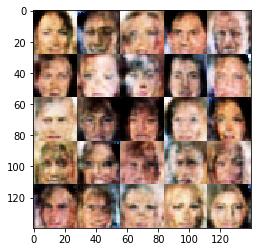

Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 1.3984 Sum Loss: 2.6419
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.6152 Sum Loss: 2.0479
Epoch 1/1... Discriminator Loss: 2.2329... Generator Loss: 0.2025 Sum Loss: 2.4354
Epoch 1/1... Discriminator Loss: 1.2057... Generator Loss: 0.9404 Sum Loss: 2.1461
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.5359 Sum Loss: 1.9183
Epoch 1/1... Discriminator Loss: 1.2227... Generator Loss: 0.8691 Sum Loss: 2.0918
Epoch 1/1... Discriminator Loss: 1.1373... Generator Loss: 0.9827 Sum Loss: 2.1201
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 1.0233 Sum Loss: 2.2399
Epoch 1/1... Discriminator Loss: 1.5096... Generator Loss: 1.8775 Sum Loss: 3.3871
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 1.1075 Sum Loss: 2.4580


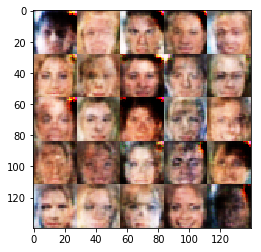

Epoch 1/1... Discriminator Loss: 0.9922... Generator Loss: 1.3435 Sum Loss: 2.3356
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 1.3513 Sum Loss: 2.8019
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.9776 Sum Loss: 2.4165
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.7473 Sum Loss: 2.0166
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.9000 Sum Loss: 2.3049
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 0.9700 Sum Loss: 2.2856
Epoch 1/1... Discriminator Loss: 1.2783... Generator Loss: 0.8316 Sum Loss: 2.1099
Epoch 1/1... Discriminator Loss: 1.6698... Generator Loss: 1.4562 Sum Loss: 3.1260
Epoch 1/1... Discriminator Loss: 1.0206... Generator Loss: 2.1352 Sum Loss: 3.1557
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.4784 Sum Loss: 1.8847


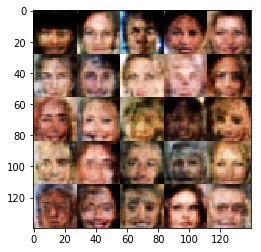

Epoch 1/1... Discriminator Loss: 0.7981... Generator Loss: 1.6748 Sum Loss: 2.4729
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 0.7358 Sum Loss: 1.9713
Epoch 1/1... Discriminator Loss: 0.9470... Generator Loss: 1.2977 Sum Loss: 2.2447
Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 1.6570 Sum Loss: 2.8094
Epoch 1/1... Discriminator Loss: 1.0442... Generator Loss: 0.8427 Sum Loss: 1.8869
Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 1.1492 Sum Loss: 2.3369
Epoch 1/1... Discriminator Loss: 0.9379... Generator Loss: 1.5936 Sum Loss: 2.5315
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 1.4088 Sum Loss: 2.5525
Epoch 1/1... Discriminator Loss: 1.0949... Generator Loss: 1.1072 Sum Loss: 2.2021
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 1.1199 Sum Loss: 2.2682


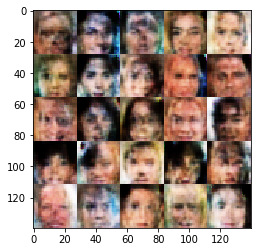

Epoch 1/1... Discriminator Loss: 0.9124... Generator Loss: 1.2839 Sum Loss: 2.1964
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 1.3735 Sum Loss: 2.7169
Epoch 1/1... Discriminator Loss: 1.1660... Generator Loss: 1.1726 Sum Loss: 2.3387
Epoch 1/1... Discriminator Loss: 1.0927... Generator Loss: 1.4733 Sum Loss: 2.5660
Epoch 1/1... Discriminator Loss: 0.9757... Generator Loss: 0.9392 Sum Loss: 1.9149
Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 1.0072 Sum Loss: 2.1551
Epoch 1/1... Discriminator Loss: 1.0456... Generator Loss: 0.7110 Sum Loss: 1.7565
Epoch 1/1... Discriminator Loss: 1.1012... Generator Loss: 1.0990 Sum Loss: 2.2003
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7878 Sum Loss: 2.1642
Epoch 1/1... Discriminator Loss: 1.1168... Generator Loss: 1.2565 Sum Loss: 2.3732


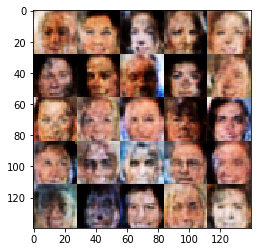

Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 1.0769 Sum Loss: 2.2025
Epoch 1/1... Discriminator Loss: 1.0743... Generator Loss: 0.8262 Sum Loss: 1.9005
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 1.1795 Sum Loss: 2.4837
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 1.6301 Sum Loss: 2.8134
Epoch 1/1... Discriminator Loss: 1.0666... Generator Loss: 0.7606 Sum Loss: 1.8272
Epoch 1/1... Discriminator Loss: 1.1670... Generator Loss: 0.9959 Sum Loss: 2.1629
Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 1.9001 Sum Loss: 3.0183
Epoch 1/1... Discriminator Loss: 0.8965... Generator Loss: 1.4620 Sum Loss: 2.3585
Epoch 1/1... Discriminator Loss: 0.8661... Generator Loss: 1.3820 Sum Loss: 2.2481
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 1.5981 Sum Loss: 2.9344


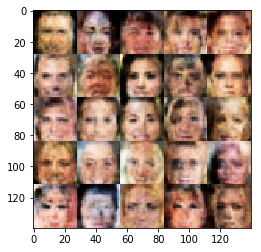

Epoch 1/1... Discriminator Loss: 0.9869... Generator Loss: 1.2588 Sum Loss: 2.2457
Epoch 1/1... Discriminator Loss: 0.8436... Generator Loss: 1.0098 Sum Loss: 1.8534
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.8916 Sum Loss: 2.3094
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.5681 Sum Loss: 2.0370
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 1.2599 Sum Loss: 2.5659
Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 1.2418 Sum Loss: 2.5053
Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 0.9273 Sum Loss: 2.1960
Epoch 1/1... Discriminator Loss: 1.5204... Generator Loss: 0.5417 Sum Loss: 2.0621
Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 1.1171 Sum Loss: 2.3258
Epoch 1/1... Discriminator Loss: 0.9077... Generator Loss: 1.6275 Sum Loss: 2.5352


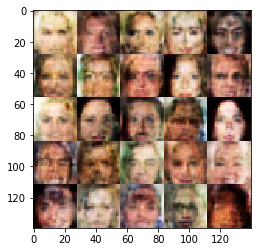

Epoch 1/1... Discriminator Loss: 1.0358... Generator Loss: 0.9901 Sum Loss: 2.0259
Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 0.9544 Sum Loss: 2.2174
Epoch 1/1... Discriminator Loss: 1.0278... Generator Loss: 0.8892 Sum Loss: 1.9170
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 0.6953 Sum Loss: 1.9635
Epoch 1/1... Discriminator Loss: 1.2857... Generator Loss: 0.5862 Sum Loss: 1.8719
Epoch 1/1... Discriminator Loss: 1.1303... Generator Loss: 0.9929 Sum Loss: 2.1232
Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 1.0378 Sum Loss: 2.2186
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 1.0746 Sum Loss: 2.3846
Epoch 1/1... Discriminator Loss: 1.0687... Generator Loss: 1.0284 Sum Loss: 2.0971
Epoch 1/1... Discriminator Loss: 1.4978... Generator Loss: 0.7158 Sum Loss: 2.2136


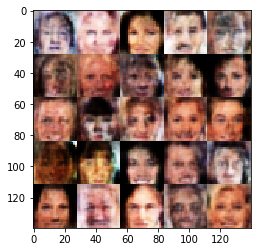

Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 1.2917 Sum Loss: 2.5091
Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 0.8933 Sum Loss: 2.0576
Epoch 1/1... Discriminator Loss: 1.0777... Generator Loss: 0.9790 Sum Loss: 2.0567
Epoch 1/1... Discriminator Loss: 1.6558... Generator Loss: 0.4208 Sum Loss: 2.0766
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 2.4006 Sum Loss: 3.8130
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 1.2506 Sum Loss: 2.6540
Epoch 1/1... Discriminator Loss: 0.9264... Generator Loss: 1.3867 Sum Loss: 2.3131
Epoch 1/1... Discriminator Loss: 1.8712... Generator Loss: 1.9113 Sum Loss: 3.7825
Epoch 1/1... Discriminator Loss: 1.0934... Generator Loss: 1.0980 Sum Loss: 2.1914
Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 0.7208 Sum Loss: 1.8321


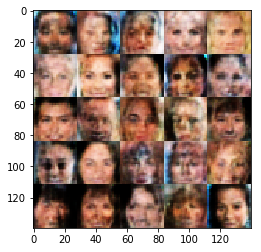

Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 0.6537 Sum Loss: 1.7986
Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 1.1719 Sum Loss: 2.2316
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 1.3171 Sum Loss: 2.4213
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 0.6167 Sum Loss: 1.8896
Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 1.3678 Sum Loss: 2.8657
Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 1.7353 Sum Loss: 2.8185
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 1.0130 Sum Loss: 2.2865
Epoch 1/1... Discriminator Loss: 0.8696... Generator Loss: 1.3255 Sum Loss: 2.1951
Epoch 1/1... Discriminator Loss: 1.2567... Generator Loss: 0.8141 Sum Loss: 2.0708
Epoch 1/1... Discriminator Loss: 1.0831... Generator Loss: 1.2300 Sum Loss: 2.3131


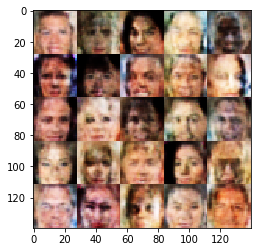

Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 0.9248 Sum Loss: 2.1634
Epoch 1/1... Discriminator Loss: 1.1495... Generator Loss: 1.0364 Sum Loss: 2.1859
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 0.6730 Sum Loss: 1.9944
Epoch 1/1... Discriminator Loss: 0.8798... Generator Loss: 1.6824 Sum Loss: 2.5623
Epoch 1/1... Discriminator Loss: 1.7401... Generator Loss: 1.2316 Sum Loss: 2.9718
Epoch 1/1... Discriminator Loss: 1.0936... Generator Loss: 0.9656 Sum Loss: 2.0592


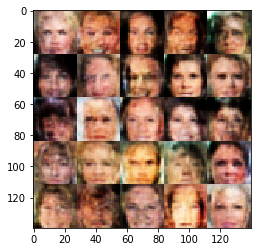

In [72]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.